In [5]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
# Torch package
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-07 10:55:26.904135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 10:55:26.904178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 10:55:26.905334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 10:55:27.870261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [6]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

# Data

In [21]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Used data from Aug 2013 till 1st March 2024 
df=df[500:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [22]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


In [23]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [24]:
df.head()

,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,SMA_21,MACD_12_26_9,MACDh_12_26_9,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
500,-0.586759,0.718521,-0.725941,-0.794212,-0.861787,-0.745251,-0.748905,-0.830099,0.857920,0.142893,...,-0.414669,-0.110213,-0.940828,0.159355,0.441655,1.705116,-0.309942,-0.730894,0.295629,-0.586759
501,-0.650690,-0.444215,-0.708600,-0.776571,-0.844034,-0.737822,-0.740482,-0.809370,0.863578,0.128215,...,-0.412881,-0.151148,0.541553,1.923313,-0.106166,1.385769,0.666877,-0.518520,0.365571,-0.650690
502,-0.703747,-0.650799,-0.709025,-0.768534,-0.832895,-0.729285,-0.731869,-0.787001,0.822823,0.005250,...,-0.412881,0.303229,0.451050,0.252315,1.465842,1.066422,1.643696,-0.306146,0.435514,-0.703747
503,-0.732619,-0.304666,-0.716653,-0.765515,-0.825489,-0.715939,-0.727467,-0.772880,0.762045,-0.141106,...,-0.412881,-0.251439,0.249758,-0.777813,-0.205409,0.013439,-0.285212,-0.817284,0.192556,-0.732619
504,-0.906976,-0.513727,-0.766512,-0.786729,-0.835188,-0.729204,-0.744258,-0.773054,0.590776,-0.522973,...,-0.412881,0.690063,1.460629,3.787425,0.076441,1.282197,-2.197634,-0.586912,0.207281,-0.906976


In [29]:
sequence_length = 30
window =6

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,3):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

In [30]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df)*0.96)
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 2758
Train sample 2647
Test sample 111


In [31]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

X_train=torch.FloatTensor(np.array(X_train))
y_train=torch.FloatTensor(np.array(y_train))

print(X_train.shape, y_train.shape)

torch.Size([871, 30, 29]) torch.Size([871, 6])


In [32]:
# Test data
X_test, y_test = create_dataset(
    df_test,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

X_test=torch.FloatTensor(np.array(X_test))
y_test=torch.FloatTensor(np.array(y_test))

print(X_test.shape, y_test.shape)

torch.Size([25, 30, 29]) torch.Size([25, 6])


In [33]:
batch_size=10
train_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test, y_test), shuffle=True, batch_size=batch_size)

## QLSTM-DRC

In [34]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [35]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=6, # number of Qubits
                n_inp_size=18, # Decide the number of input to quantum model
                n_qlayers=12, #  
                n_vrotations=3,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size 
        self.hidden_size = hidden_size
        self.n_inp_size=n_inp_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.n_vrotations = n_vrotations
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state
        
        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget, shots=None)
        self.dev_input = qml.device(self.backend, wires=self.wires_input, shots=None)
        self.dev_update = qml.device(self.backend, wires=self.wires_update, shots=None)
        self.dev_output = qml.device(self.backend, wires=self.wires_output, shots=None)
        
        # NO-DRC circuit
        def VQC(inputs, weights, wires_type): # inputs, weights, self.wires_update  
            qml.Rot(*inputs[:3], wires=wires_type[0])
            qml.Rot(*inputs[3:6], wires=wires_type[1])
            qml.Rot(*inputs[6:9], wires=wires_type[2])
            qml.Rot(*inputs[9:12], wires=wires_type[3])
            qml.Rot(*inputs[12:15], wires=wires_type[4])
            qml.Rot(*inputs[15:18], wires=wires_type[5])
            for p1,p2,p3,p4,p5,p6 in zip(weights[:2],weights[2:4],weights[4:6],weights[6:8],weights[8:10],weights[10:12]):
                qml.CNOT(wires=[wires_type[0], wires_type[1]])
                qml.CNOT(wires=[wires_type[1], wires_type[2]])
                qml.CNOT(wires=[wires_type[2], wires_type[3]]) 
                qml.CNOT(wires=[wires_type[3], wires_type[4]])
                qml.CNOT(wires=[wires_type[4], wires_type[5]])
                qml.Rot(*p1, wires=wires_type[0])
                qml.Rot(*p2, wires=wires_type[1])
                qml.Rot(*p3, wires=wires_type[2])
                qml.Rot(*p4, wires=wires_type[3])
                qml.Rot(*p5, wires=wires_type[4])
                qml.Rot(*p6, wires=wires_type[5])
               
        def _circuit_forget(inputs, weights):
            VQC(inputs, weights, self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch", diff_method='backprop')

        def _circuit_input(inputs, weights):
            VQC(inputs, weights, self.wires_input)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch", diff_method='backprop')

        def _circuit_update(inputs, weights):
            VQC(inputs, weights, self.wires_update)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch", diff_method='backprop')

        def _circuit_output(inputs, weights):
            VQC(inputs, weights, self.wires_output)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch", diff_method='backprop')

        weight_shapes = {"weights": (self.n_qlayers, self.n_vrotations)}
        print(f"weight_shapes = (n_qlayers, n_vrotations) = ({self.n_qlayers}, {self.n_vrotations})")

        self.clayer_in = torch.nn.Linear(self.concat_size, self.n_inp_size)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [39]:
class QShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=6, n_qlayers=12): # n_qlayers decide the weights
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2 # Number of QLSTM layer

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear_1 = nn.Linear(in_features=self.hidden_units, out_features=1)
        self.linear_2 = nn.Linear(in_features=30, out_features=6)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_l1, (hn, _) = self.lstm(x, (h0, c0))
        out_l2 = self.linear_1(out_l1)
        out = self.linear_2(torch.squeeze(out_l2))
        return out

In [40]:
learning_rate = 0.05
num_hidden_units = 16
 
Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=6) # Number of Qubits
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations) = (12, 3)


In [ ]:
quantum_loss_train = []
quantum_loss_test = []
num_epoch=10
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    end = time.time()
    test_loss = test_model(test_loader, Qmodel, loss_function)
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Epoch 0
---------


/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 0.25058370104736905
Test loss: 0.06684860835472743
Execution time 4481.398415803909
Epoch 1
---------
Train loss: 0.0718173435465856
Test loss: 0.02435303044815858
Execution time 4494.7178654670715
Epoch 3
---------
Train loss: 0.06157595559488982
Test loss: 0.05188494548201561
Execution time 4478.396293401718
Epoch 4
---------
Train loss: 0.054859120451675895
Test loss: 0.02891042393942674
Execution time 4566.678709745407
Epoch 5
---------
Train loss: 0.051645751471038566
Test loss: 0.027353941773374874
Execution time 4559.287553071976
Epoch 6
---------
Train loss: 0.05068334604782814
Test loss: 0.03344278410077095
Execution time 4711.864957809448
Epoch 7
---------
Train loss: 0.04823115152645518
Test loss: 0.021603199342886608
Execution time 4707.419192314148
Epoch 8
---------
Train loss: 0.04586728435771709
Test loss: 0.0270366333425045
Execution time 4573.284925699234
Epoch 9
---------


In [42]:
quantum_loss_test

[0.06684860835472743,
 0.03279369976371527,
 0.02435303044815858,
 0.05188494548201561,
 0.02891042393942674,
 0.027353941773374874,
 0.03344278410077095,
 0.021603199342886608,
 0.0270366333425045,
 0.024611884107192356]

In [45]:
quantum_loss_train

[0.25058370104736905,
 0.09632511977741326,
 0.0718173435465856,
 0.06157595559488982,
 0.054859120451675895,
 0.051645751471038566,
 0.05068334604782814,
 0.04823115152645518,
 0.04586728435771709,
 0.045101567298512564]

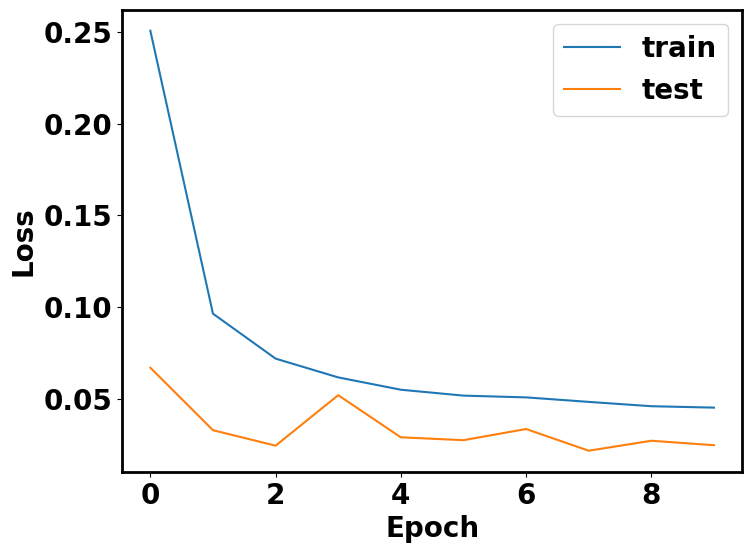

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), quantum_loss_train, label='train')
plt.plot(range(num_epoch), quantum_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [47]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [ ]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, Qmodel)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
    
# Prepare data to evaluate test accuracy of lstm
test_eval_loader = DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=batch_size)
y_test_pred_lstm=predict(test_eval_loader, Qmodel)
y_test_lstm=[]
for X, y in test_eval_loader:
    y_test_lstm.append(y)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
mae_train_qlstm, rmse_train_qlstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_qlstm)
print('RMSE train error is',rmse_train_qlstm)
mae_test_qlstm, rmse_test_qlstm= cal_metrics(y_test_lstm,y_test_pred_lstm)
print('MAE test error is',mae_test_qlstm)
print('RMSE test error is',rmse_test_qlstm)

MAE train error is 91.46921595660123
RMSE train error is 119.08889302340421
MAE test error is 68.85015360514323
RMSE test error is 83.37227121988933


In [55]:
total_params_Q = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)

print("No. of parameters for QLSTM: ", total_params_Q)

No. of parameters for QLSTM:  1143
